In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

In [2]:
path = 'stars_results/test'
df = pd.read_csv(os.path.join(path, 'stars/results.csv'))
df.head()

,name,f_evol_16th,f_evol_50th,f_evol_84th,f_evol_ess_bulk,f_evol_ess_mean,f_evol_ess_sd,f_evol_ess_tail,f_evol_hpd_3%,f_evol_hpd_97%,...,mhs_ess_mean,mhs_ess_sd,mhs_ess_tail,mhs_hpd_3%,mhs_hpd_97%,mhs_mcse_mean,mhs_mcse_sd,mhs_mean,mhs_r_hat,mhs_sd
0,0,0.224482,0.378846,0.491236,3967.188712,3980.267261,3980.267261,5836.437684,0.128110,0.568435,...,24816.577630,14783.076082,15754.912242,-0.070582,0.183341,0.000425,0.000390,0.053016,1.000295,0.067008
1,1,0.271148,0.438811,0.563243,3069.275281,3083.831658,3083.831658,5934.514476,0.167167,0.652858,...,28133.738851,24515.110006,15097.190177,0.017438,0.271700,0.000403,0.000305,0.148206,1.000288,0.067615
2,2,0.099509,0.213878,0.332612,4859.643216,4999.811735,4951.495891,7265.289432,0.027211,0.394700,...,14934.637284,13567.141707,8048.294710,0.226365,0.464623,0.000525,0.000390,0.346878,1.001012,0.064211
3,3,0.181609,0.354451,0.489205,3843.855534,3976.357948,3976.357948,5240.116433,0.074328,0.577440,...,31985.529775,17140.739771,15611.954594,-0.065082,0.196593,0.000385,0.000372,0.063226,1.000842,0.068900
4,4,0.351028,0.511859,0.635233,3724.490515,3769.736110,3740.785492,7907.776808,0.248301,0.719555,...,34549.839156,8901.086550,15496.820474,-0.121527,0.139449,0.000372,0.000518,0.007885,1.000483,0.069118


In [3]:
def get_var(var_name):
    x = df[f'{var_name}_50th'].values
    return x, np.max([df[f'{var_name}_84th'].values - x, x - df[f'{var_name}_16th'].values], axis=0)

In [4]:
y, y_unc = get_var('yi')
z, z_unc = get_var('zi')

<ErrorbarContainer object of 3 artists>

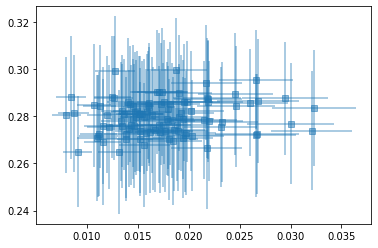

In [6]:
fig, ax = plt.subplots()
ax.errorbar(z, y, xerr=z_unc, yerr=y_unc, linestyle='None', marker='s', alpha=0.5)

In [7]:
mlt, mlt_unc = get_var('mlt')

In [8]:
with pm.Model() as model:
    yp = pm.Normal('yp', 0.247, 0.001)
    dydz = pm.Deterministic('dydz', 4.0 * pm.Beta('dydz_offset', 1.2, 1.2))
    sigma_yi = pm.Lognormal('sigma_yi', 0.01, 1.0)

    mu_mlt = pm.Deterministic('mu_mlt', 1.5 + pm.Beta('mu_mlt_offset', 1.2, 1.2))
    sigma_mlt = pm.Lognormal('sigma_mlt', 0.1, 1.0)
    
    z_latent = pm.Normal('z_latent', z, z_unc, shape=len(z))
    y_offset = pm.Normal('y_offset', 0.0, 1.0, shape=len(z))
    mu_yi = yp + dydz * z_latent
    y_pred = pm.Deterministic('y_pred', mu_yi + sigma_yi * y_offset)
    
    mlt_offset = pm.Normal('mlt_offset', 0.0, 1.0, shape=len(mlt))
    mlt_pred = pm.Deterministic('mlt_pred', mu_mlt + sigma_mlt * mlt_offset)
    
    y_obs = pm.Normal('y_obs', y_pred, y_unc, observed=y)
    mlt_obs = pm.Normal('mlt_obs', mlt_pred, mlt_unc, observed=mlt)

In [9]:
draws = 10000
chains = 2

with model:
    trace = pm.sample(draws=draws, chains=chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mlt_offset, y_offset, z_latent, sigma_mlt, mu_mlt_offset, sigma_yi, dydz_offset, yp]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 25 seconds.


/Users/ajl573/.virtualenvs/stellr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


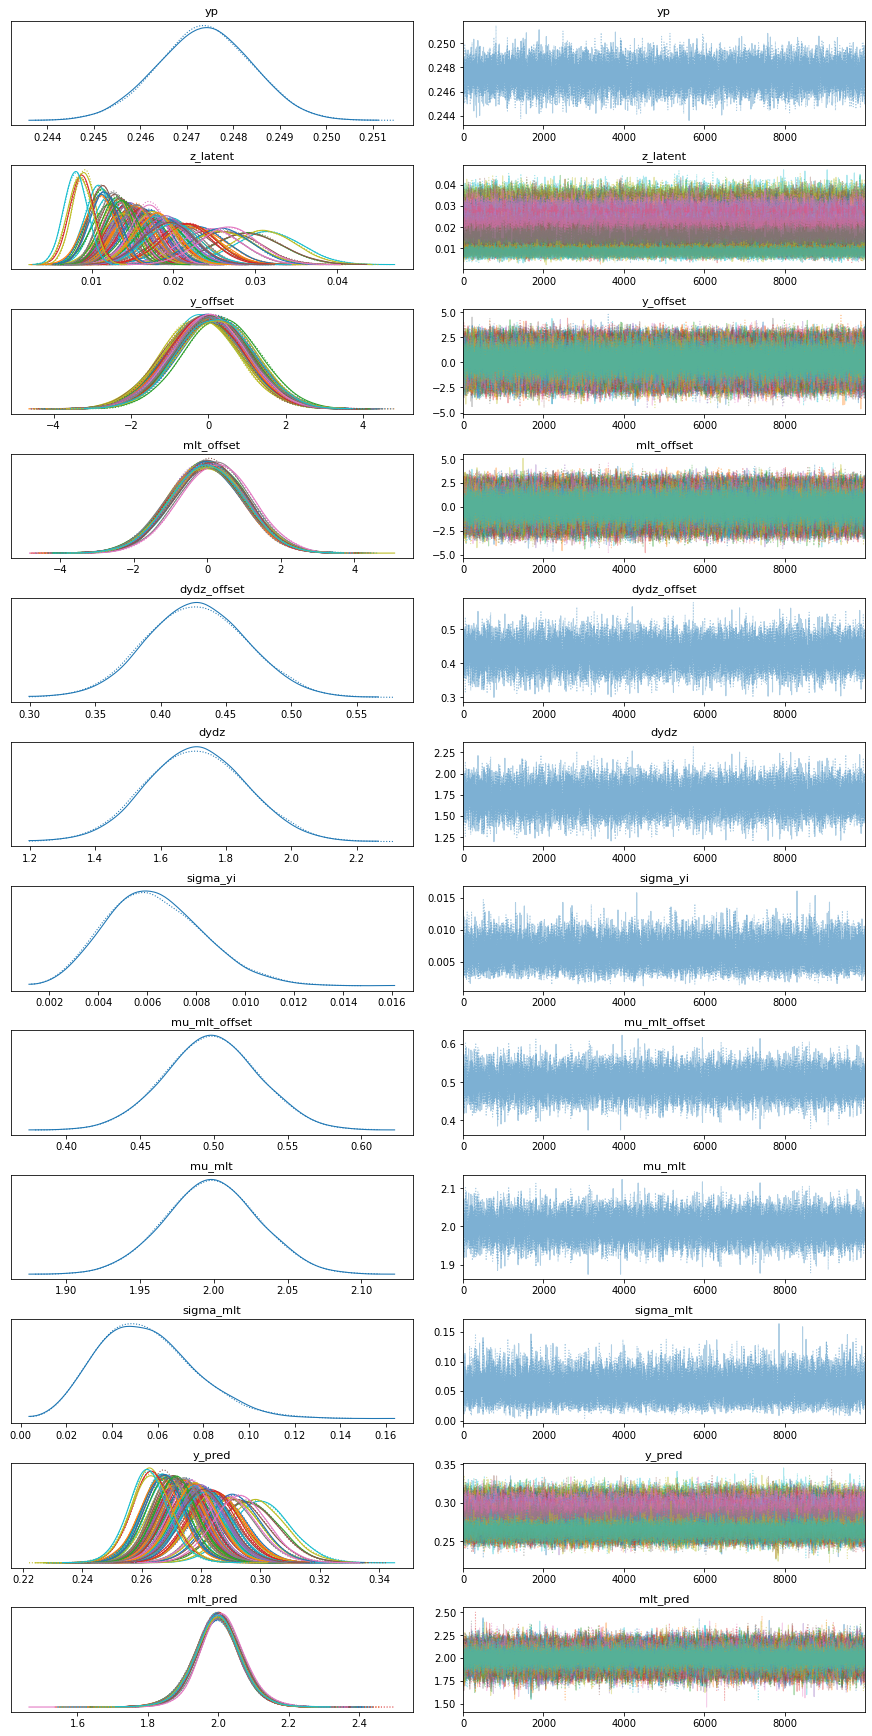

In [10]:
pm.traceplot(trace, compact=True);

In [11]:
stat_funcs = {
    '50th': np.median,
    '16th': lambda x: np.percentile(x, 16.0),
    '84th': lambda x: np.percentile(x, 84.0),
}

In [12]:
summary = pm.summary(trace, round_to='none', stat_funcs=stat_funcs)
summary.head()

/Users/ajl573/.virtualenvs/stellr/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,50th,16th,84th
yp,0.247390,0.000996,0.245450,0.249181,0.000006,0.000005,23914.842810,23914.842810,23924.405124,13181.131281,1.000287,0.247396,0.246399,0.248384
z_latent[0],0.016175,0.002321,0.011789,0.020479,0.000014,0.000010,26660.938470,25438.377530,26669.178791,12343.385527,1.000124,0.016175,0.013860,0.018481
z_latent[1],0.020033,0.003014,0.014477,0.025778,0.000020,0.000014,23823.816691,23462.188229,23828.854480,12630.108714,1.000096,0.020033,0.017034,0.023029
z_latent[2],0.028980,0.004167,0.021203,0.036811,0.000025,0.000018,27737.012630,27175.693312,27757.511625,11653.669191,1.000248,0.028994,0.024789,0.033109
z_latent[3],0.016226,0.002475,0.011645,0.020859,0.000016,0.000011,25035.488712,24523.391567,25044.567070,11905.245721,1.000009,0.016207,0.013734,0.018725


In [13]:
summary.to_csv(os.path.join(path, 'analysis_results.csv'), index_label='var_name')

In [16]:
pm.save_trace(trace, os.path.join(path, 'analysis/trace'))

'stars_results/test/analysis/trace'

Text(0.5, 0, 'sigma_mlt')

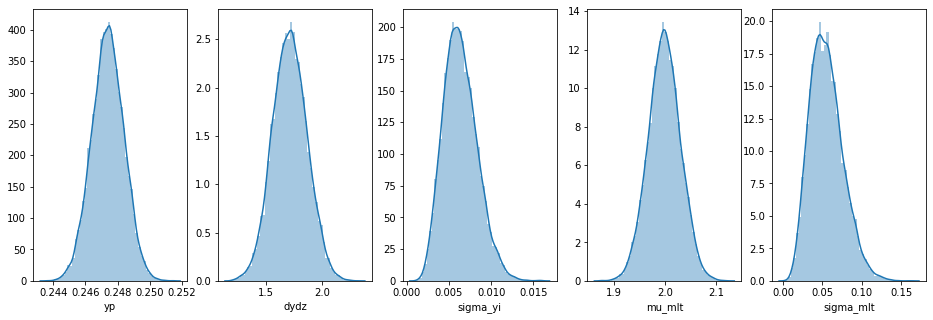

In [17]:
fig, ax = plt.subplots(1, 5, figsize=[16, 5])
sns.distplot(trace['yp'], ax=ax[0])
ax[0].set_xlabel('yp')
sns.distplot(trace['dydz'], ax=ax[1])
ax[1].set_xlabel('dydz')
sns.distplot(trace['sigma_yi'], ax=ax[2])
ax[2].set_xlabel('sigma_yi')
sns.distplot(trace['mu_mlt'], ax=ax[3])
ax[3].set_xlabel('mu_mlt')
sns.distplot(trace['sigma_mlt'], ax=ax[4])
ax[4].set_xlabel('sigma_mlt')

In [18]:
n_samples = 100
rand_ids = np.random.randint(0, chains*draws-1, size=(1, n_samples))

In [19]:
z_mod = np.array([[0.], [0.05]]) * np.ones((2, n_samples))
y_mod = trace['dydz'][rand_ids] * z_mod + trace['yp'][rand_ids]

In [20]:
y_upper = y_mod + trace['sigma_yi'][rand_ids]
y_lower = y_mod - trace['sigma_yi'][rand_ids]

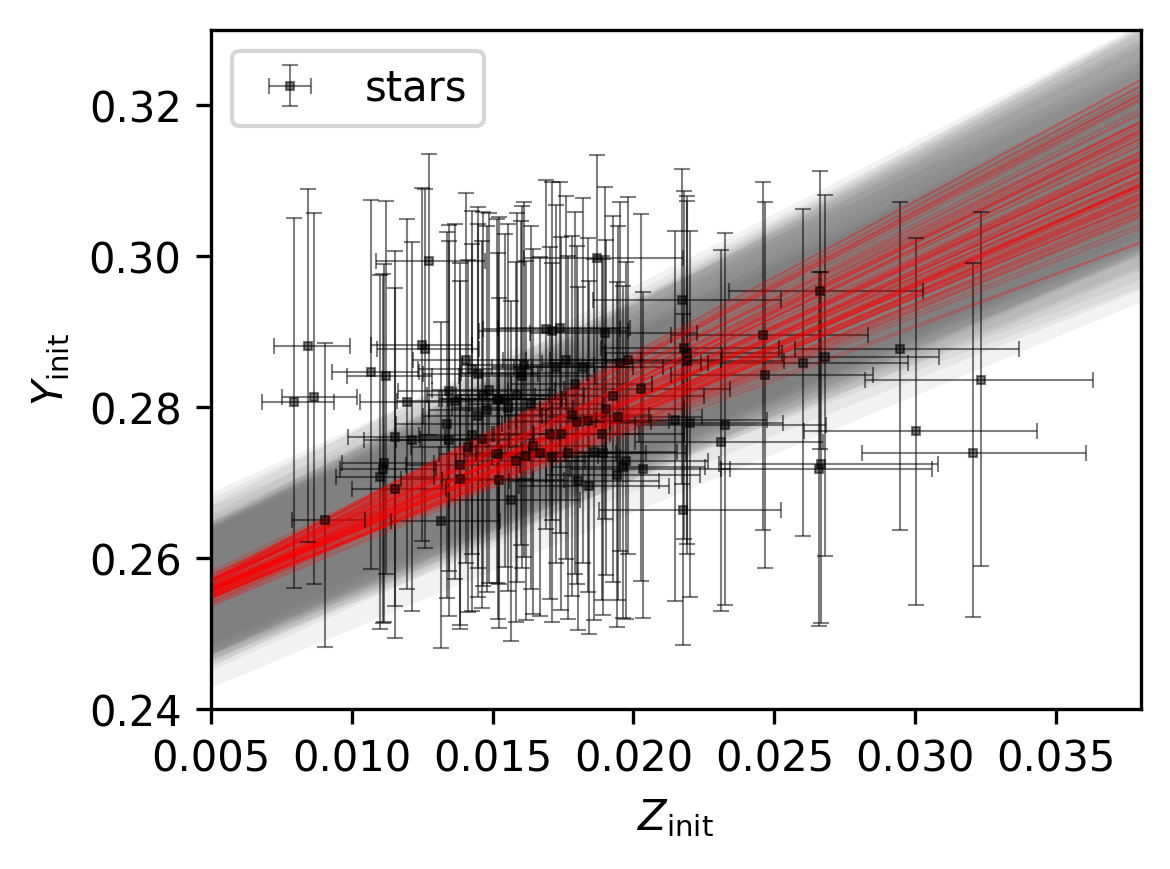

In [21]:
plt.figure(figsize=(4, 3), dpi=300)

for i in range(n_samples):
    plt.fill_between(z_mod[:, i], y_upper[:, i], y_lower[:, i], facecolor='grey', edgecolor='none', alpha=0.1)

l_mod = plt.plot(z_mod, y_mod, 'r', alpha=0.2, linewidth=0.5)

l_data = plt.errorbar(x=df['zi_50th'], y=df['yi_50th'],
             xerr=[df['zi_50th']-df['zi_16th'], df['zi_84th']-df['zi_50th']], 
             yerr=[df['yi_50th']-df['yi_16th'], df['yi_84th']-df['yi_50th']],
             linestyle='none', alpha=0.5, color='k',
             marker='s', markersize=2, elinewidth=0.5,
             capsize=2, label='stars', markeredgewidth=0.5,
#              zorder=1
             )

# if 'SUN' in df['name'].to_numpy():
#     s = df[df['name']=='SUN']
#     plt.plot(s['zi_50th'], s['yi_50th'], c='gold', marker=r'$\odot$', markersize=8,
#                  linestyle='none', markeredgewidth=0.5, zorder=3, label='sun'
#              )

plt.xlabel(r'$Z_\mathrm{init}$')
plt.ylabel(r'$Y_\mathrm{init}$')

plt.xlim(0.005, 0.038)
plt.ylim(0.24, 0.33)

plt.legend();
# plt.legend(handles=[l_mod[0], l_data], labels=[r'$Y_\mathrm{model}(Z)$', 'df']);

plt.savefig(os.path.join(path, 'helium_enrichment_fit.png'), bbox_inches='tight')

In [22]:
from corner import corner

In [23]:
phi = ['dydz', 'yp', 'sigma_yi', 'mu_mlt', 'sigma_mlt']

In [24]:
xs = np.array([trace[name] for name in phi]).T
xs

array([[1.77926812, 0.24583895, 0.00589248, 2.0161616 , 0.038539  ],
       [1.81659937, 0.24589715, 0.00723156, 2.03197703, 0.03185772],
       [1.48804634, 0.24754563, 0.00431426, 1.97653905, 0.06900597],
       ...,
       [1.64349181, 0.24909361, 0.00819174, 1.97438095, 0.11565337],
       [1.64790499, 0.24940164, 0.00574157, 1.99292731, 0.03936455],
       [1.71100653, 0.24522546, 0.00483349, 2.01992293, 0.05366866]])

In [25]:
hyperparams = pd.read_csv('../../data/tracks/test_stars/test_stars_hyperparams.csv', names=['true'], index_col=0)
hyperparams

,true
dydz,1.8000
yp,0.2467
sigma_yi,0.0080
mu_mlt,2.0000
sigma_mlt,0.0800
m_zi,0.0160
sigma_zi,0.3000


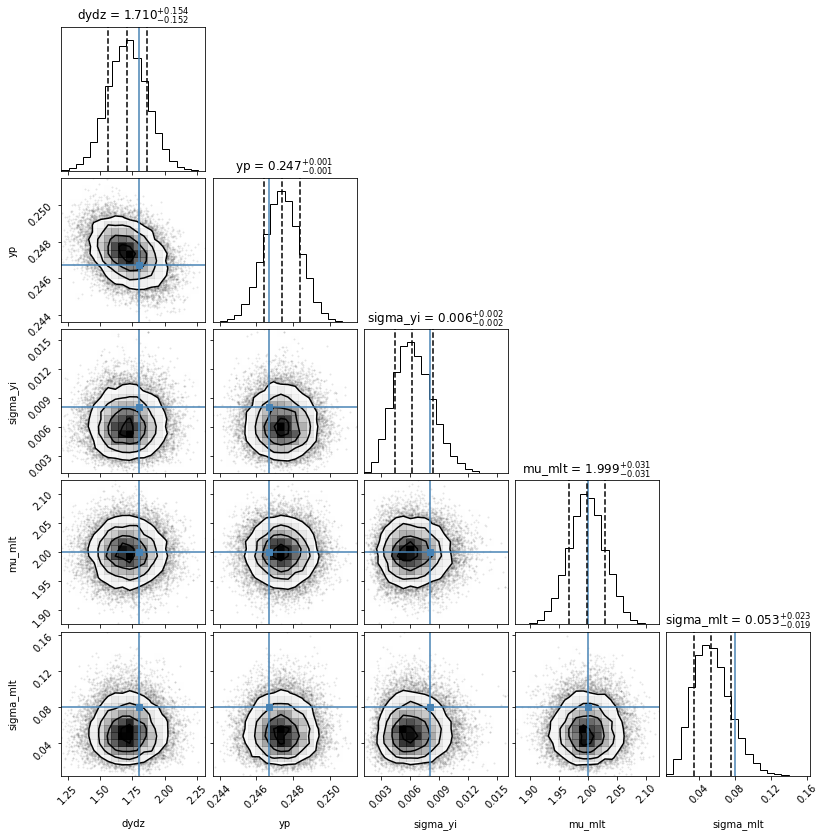

In [26]:
fig = corner(
    xs, truths=hyperparams.loc[phi, 'true'], quantiles=[.16, .5, .84],
    labels=phi, show_titles=True, title_fmt='.3f'
)

fig.savefig(os.path.join(path, 'corner_plot.png'))